# Autoencoders: Introduction 

Autoenconders are quite simple MLP models that are able to perform **semi-supervised learnig**. They are often used for
- Dimensionality reduction
- Noise removal

Semi-supervised learning is unsupervised learning but we somehow do have information of the correct labels at some stage during training; however, not during testing, so it does not make sense to use metrics such as the RMSE to evaluate our model. In other words, there is not always ground truth available.

The autoencoder is **designed to reproduce its input at the output layer**. Therefore, **the number of input and output neurons is the same**; actually, that's the main difference wrt. a regular MLP.

The autoencoder has an encoding part followed by an decoding part:
- The encoder simplifies or reduces the number of neurons: information representation is compressed to a middle hidden layer which contains the most important information.
- The decoder expands the information again from the middle hidden layer; the final layer should yield the information as smilar as possibe to the input.

Some notes:
- This is equivalent to PCA: the most important components or dimensions are detected.
- Note that dimensionality reduction does not mean feature selection! In fact, the idea is that we keep all relevant features while noise is removed

## Dimensionality Reduction

If we want to apply an autoencoder dor dimensionality reduction, we train it with its two parts: the encoder and the decoder; however, then, only the encoder part is taken until the middle hidden layer, which compresses the most important information, i.e., it reduces the dimensions of the data.

Applications of dimensionality redection:
- Compress data
- Visualize data in lower dimensions. That is a very important application/point: in the case of N dimensional data, we are able to reduce it to 2D so that we can plot it. **Visualization is key to understand how close some classes are from each other and if they overlap or not!**
- Reveal hidden relationships not clearly seen in higher dimensions

Here an example is provided with a synthetic dataset.
**Note that, at least in my case, the trained model was not always able to reduce the dimensions of the datapoints so that they belonged to disjoint groups.**

### 1. Create the Dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# We use SKLearn to create datasets consisting of blob-like point clouds 
from sklearn.datasets import make_blobs

In [8]:
# We create point clouds of with the following parameters
# - n_samples: how many data points
# - n_features: the dimension of each point
# - centers: the number of groups or blobs
# - cluster_std: the noise or dispersion around each center
# - random_state: seed for random generator (same random for same seed)
data = make_blobs(n_samples=300,
                  n_features=2,
                  centers=2,
                  cluster_std=1.0,
                  random_state=101)

In [9]:
# We unpack the data
X,y = data

In [13]:
# Data: feature values = points
X[0:5]

array([[ -8.87772115,  -6.76007802],
       [  0.630638  ,   3.10707466],
       [ -0.24060881,   2.82068999],
       [ -7.83909113,  -8.20754485],
       [-10.9729082 ,  -7.39067645]])

In [15]:
# Labels for each point: center/cluster/group 0 or 1
y[0:5]

array([1, 0, 0, 1, 1])

In [17]:
# Now, we add a 3rd feature: NOISE
# The idea is we'd like to remove that noise!
np.random.seed(101)
z_noise = np.random.normal(size=len(X))
z_noise = pd.Series(z_noise)

In [18]:
z_noise

0      2.706850
1      0.628133
2      0.907969
3      0.503826
4      0.651118
         ...   
295    1.523750
296    1.290230
297   -1.478319
298    0.214234
299   -0.240510
Length: 300, dtype: float64

In [22]:
# We assemble everything to a dataframe
features = pd.DataFrame(X)
features = pd.concat([features,z_noise],axis=1)
# X3 is pure noise
features.columns = ['X1','X2','X3']

In [23]:
features.head()

,X1,X2,X3
0,-8.877721,-6.760078,2.706850
1,0.630638,3.107075,0.628133
2,-0.240609,2.820690,0.907969
3,-7.839091,-8.207545,0.503826
4,-10.972908,-7.390676,0.651118


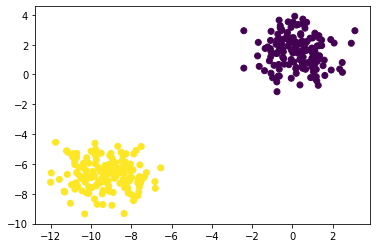

In [196]:
# We plot our dataset in 2D
# We use the label as hue for marker colors
plt.scatter(features['X1'],features['X2'],c=y)

In [197]:
# We can also plot our dataset in 3D using mpl_toolkit from mtplotlib
# https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html

In [198]:
from mpl_toolkits.mplot3d import Axes3D

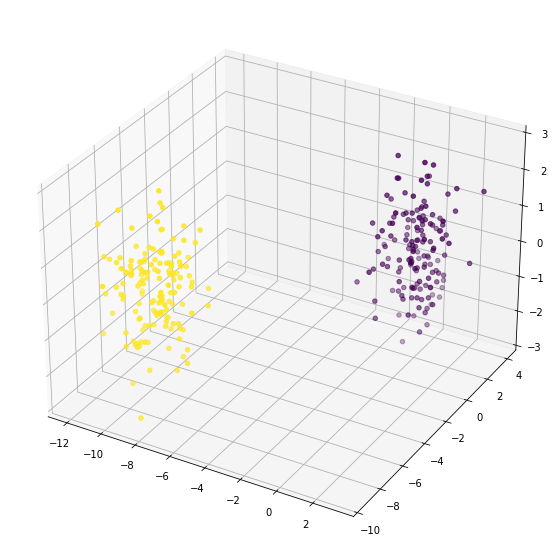

In [199]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features['X1'],features['X2'],features['X3'],c=y)

In [294]:
# We scale the data
from sklearn.preprocessing import MinMaxScaler

In [295]:
# Note that there is no data in terms on how to reduce the dimensionality
# Thus, we fir the scaling to the complete dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

### 2. Create the Model

In [296]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [297]:
# It is quite normal to use the SGD optimization for Autoencoders
# and also a learning rate that can be varied during the traning if we see
# that the hidden layer is having difficulties
from tensorflow.keras.optimizers import SGD

In [298]:
# We create the following model
# input 3 --> hidden 2 --> output 3

In [299]:
# in 3 to 2
encoder = Sequential()
encoder.add(Dense(units=2,activation='relu',input_shape=[3]))

In [300]:
# in 2 to 3
decoder = Sequential()
decoder.add(Dense(units=3,activation='relu',input_shape=[2]))

In [301]:
# We concatenate both the encoder and the decoder
autoencoder = Sequential([encoder,decoder])

In [313]:
# Portilla chose a learning rate of 1.5
# I thoght that's a very high lr
# However, I tried lower lrs and it does not always work well...
autoencoder.compile(loss='mse',optimizer=SGD(lr=1.5))

In [303]:
autoencoder.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_49 (Sequential)   (None, 2)                 8         
_________________________________________________________________
sequential_50 (Sequential)   (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


#### Train

In [314]:
# We train by requiring the same output as the input
# Since this is a small dataset and a small model, it trains super fast
# Note that more epochs did not lead to better results in my trials...
autoencoder.fit(scaled_data,scaled_data,epochs=5)

Train on 300 samples
Epoch 1/5
300/300 [==============================] - 0s 792us/sample - loss: 0.2202
Epoch 2/5
300/300 [==============================] - 0s 51us/sample - loss: 0.2200
Epoch 3/5
300/300 [==============================] - 0s 34us/sample - loss: 0.2202
Epoch 4/5
300/300 [==============================] - 0s 31us/sample - loss: 0.2204
Epoch 5/5
300/300 [==============================] - 0s 49us/sample - loss: 0.2208


#### Infer

In [309]:
# After the training we take only the ENCODER
# and pass our data through it
encoded_2dim = encoder.predict(scaled_data)

In [306]:
#encoded_2dim

In [310]:
# The datapoints are converted from 3D to 2D
encoded_2dim.shape

(300, 2)

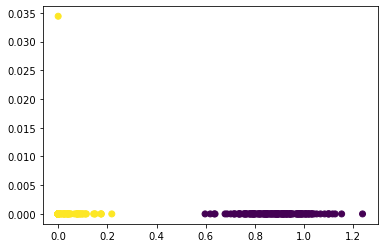

In [315]:
# We plot and color them according to their cluster/class (hue)
# We see whether the color groups are separated
# If they are, then it worked!
# The idea is to reduce dimensions of a dataset so that it is possible to visualize it
# Then, for instance, we see how separable classes are
# NOTE: it does not always work as expected...
# In fact I tried different epoch numbers & learning rates
# and it is not deterministric
plt.scatter(encoded_2dim[:,0],encoded_2dim[:,1],c=y)